<a href="https://colab.research.google.com/github/erickvicente/HolaMundo/blob/master/Copia_de_Actividad_2_EV_%2B_AM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MODELO DE PREDICCIÓN DE LA RENTABILIDAD DE UN ATM**
*By: Erick Vicente y Angie Maio*

DICCIONARIO DE DATOS: 
1. **'ubicacion_2':** Si el ATM se encuentra instalado en Oficina o no.
2. **'antiguedad':** Años de antiguedad del ATM.
3. **'tipo_instalacion':** Si el abastecimiento del ATM se realiza en zona con acceso al público o por dentro de la oficina.
4. **'ut':** Nivel de disponibilidad del ATM (% de tiempo que el cajero ha estado atendiendo a clientes, promedio de enero a agosto 2022).
5. **'rentable':** Indicador generado en base al promedio de transacciones realizadas en el ATM de enero a agosto 2022. Es 1 cuando está por encima de la mediana. 


---



In [48]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab as pl
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import trim_mean
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

style.use('ggplot') or plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Regresión Logística
from sklearn.linear_model import LogisticRegression
# Metricas
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split

In [50]:
#Carga del archivo ATM
from google.colab import files
data_to_load = files.upload()
import io 
atm = pd.read_csv(io.BytesIO(data_to_load['ATM - Consolidado.csv']), header=0, sep=',')
atm.shape

Saving ATM - Consolidado.csv to ATM - Consolidado (2).csv


(1868, 49)

In [55]:
atm2 = atm.copy()
#Se considera 1-OFICINA porque se cuenta con mayor cantidad de ATM instalados en oficina
atm2['ubicacion_2'] = [1 if s =='OFICINA' else 0 for s in atm2['ubicacion']]
#Se considera 1-LOBBY porque se cuenta con mayor cantidad de tipo de instalación Lobby
atm2['tipo_instalacion'] = [1 if s =='LOBBY' else 0 for s in atm2['tipo_instalacion']]
#Se considera solo el ATM tipo "DISPENSADOR"
atm2.drop(atm2.loc[atm2['tipo']=='MONEDERO'].index, inplace=True)
atm2.drop(atm2.loc[atm2['tipo']=='DEPOSITO'].index, inplace=True)
#Se categoriza la distribución física en base a la cantidad de ATM por tipo de distribución física
conditionlist = [
    (atm2['distribucion_fisica'] == 'ZONA SERVICING'),
    (atm2['distribucion_fisica'] == 'INTERIOR DE OFICINA'),
    (atm2['distribucion_fisica'] == 'ISLA')]
choicelist = [0,2,1]
atm2['distribucion_fisica_2'] = np.select(conditionlist, choicelist, default='Not Specified')
atm2['distribucion_fisica_2'] = atm2['distribucion_fisica_2'].astype(int, errors = 'raise')
#Se categoriza los encargados en base de abastecimiento en base a la cantidad de ATMs asignados
conditionlist = [
    (atm2['encargado'] == 'OFICINA'),
    (atm2['encargado'] == 'PROSEGUR'),
    (atm2['encargado'] == 'HERMES')]
choicelist = [0,1,2]
atm2['encargado_2'] = np.select(conditionlist, choicelist, default='Not Specified')
atm2['encargado_2'] = atm2['encargado_2'].astype(int, errors = 'raise')
#Se considera 1-URBANO porque contamos con más ATMs en zona urbana
atm2['zonificacion'] = [0 if s =='URBANO' else 1 for s in atm2['zonificacion']]
atm3 = atm2.copy()

### **ANALISIS DEL MODELO 1** 

---



**BALANCEANDO DATOS**

In [56]:
#Calculamos la media de las transacciones
mediatx = atm2['prom_tx'].mean()
atmgood2 = atm2.query('prom_tx >= @mediatx')
print(mediatx)

5519.23125


In [57]:
#Filtramos la tabla en base al promedio de las tx
#1 es rentable, 0 no es rentable.
atm2['rentable']=1*((atm2.prom_tx>=mediatx))
atm2.rentable.value_counts()

0    751
1    749
Name: rentable, dtype: int64

In [58]:
#Seleccionamos las variables dependientes e independientes
col_select = ['ubicacion_2','antiguedad','tipo_instalacion','encargado_2','distribucion_fisica_2','zonificacion','ut','rentable'] 
atm_filtro = atm2.filter(col_select)
atm_filtro

,ubicacion_2,antiguedad,tipo_instalacion,encargado_2,distribucion_fisica_2,zonificacion,ut,rentable
0,1,1,0,0,0,0,100.00,0
1,1,1,0,0,0,0,100.00,0
2,1,4,1,0,0,0,98.78,1
3,1,8,0,0,0,0,97.83,0
4,1,4,1,1,0,0,99.23,0
...,...,...,...,...,...,...,...,...
1842,1,1,0,0,0,0,90.31,0
1843,1,4,1,1,0,0,91.32,0
1844,0,1,0,0,0,0,96.43,0
1845,0,1,0,0,0,0,100.00,0


In [59]:
#balanceamos los datos
n1 = len(atm_filtro[atm_filtro.rentable==1])
d0 = atm_filtro[atm_filtro.rentable==0]
d0 = d0.sample(n1,replace=False,random_state=42)
d1 = atm_filtro[atm_filtro.rentable==1]
data_filter = pd.concat([d0, d1])
data_filter = shuffle(data_filter)
data_filter.rentable.value_counts()

0    749
1    749
Name: rentable, dtype: int64

**ANÁLISIS DE CORRELACIÓN**

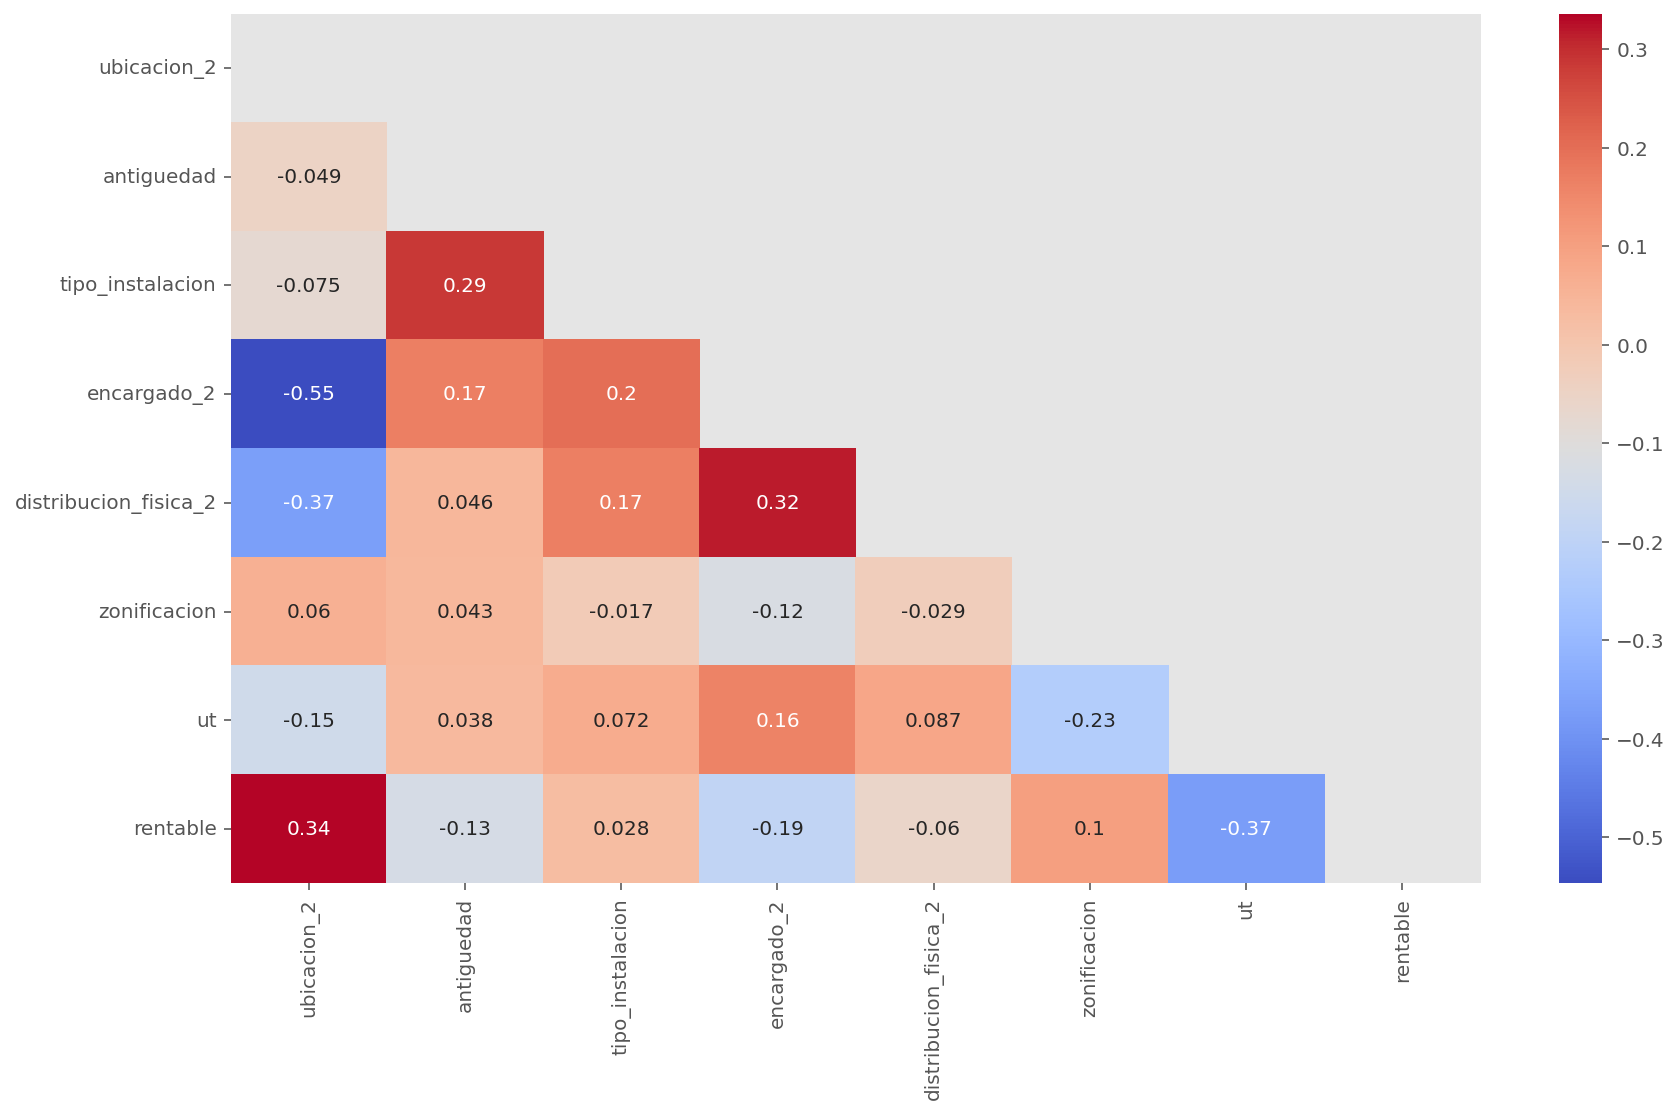

In [60]:
fig, ax = plt.subplots(figsize=(14,8))
mask = np.triu(np.ones_like(atm_filtro.corr(method='spearman')))
dataplop = sns.heatmap(atm_filtro.corr(method='spearman'), cmap = 'coolwarm', annot = True, mask=mask)
plt.show()

**ENTRENANDO EL MODELO**

In [61]:
data_filter = data_filter.to_numpy()
nrow,ncol = data_filter.shape
y = data_filter[:,-1]
X = data_filter[:,0:ncol-1]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,random_state=42)
scaled_X = StandardScaler()
X_train = scaled_X.fit_transform(X_train)
X_test = scaled_X.transform(X_test)
clf1 = LogisticRegression(C=0.01,class_weight="balanced").fit(X_train, y_train)
y_pred1 = clf1.predict(X_test)
y_score1 = clf1.decision_function(X_test)

**Calculando las métricas de evaluación**

In [63]:
fpr1, tpr1, _ = roc_curve(y_test, y_score1, pos_label=clf1.classes_[1])

In [64]:
accuracy_score(y_test, y_pred1)

0.6688888888888889

In [65]:
precision_score(y_test, y_pred1)

0.6893617021276596

In [66]:
recall_score(y_test, y_pred1)

0.680672268907563

In [67]:
metrics.auc(fpr1, tpr1)

0.7343725225939433

In [68]:
mean_absolute_error(y_test, y_pred1)

0.33111111111111113

In [69]:
mean_squared_error(y_test, y_pred1)

0.33111111111111113

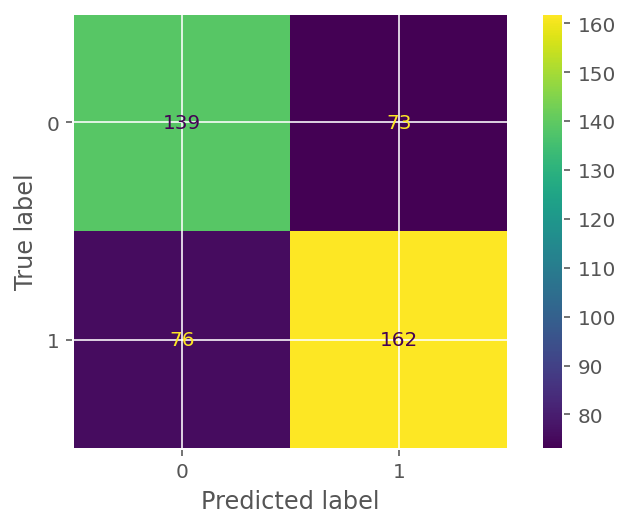

In [70]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred1)

cm_display = ConfusionMatrixDisplay(cm).plot()

**Analizamos las variables para seleccionar aquellas que mejoren nuestro modelo de predicción**

In [43]:
#Mostramos los coeficientes
print("Intercept:", clf1.intercept_)
print("Accuracy de entrenamiento:", clf1.score(X, y))
print("Coeficiente:", pd.DataFrame(clf1.coef_, columns=atm_filtro.columns[0:7]).T)

Intercept: [0.00849671]
Accuracy de entrenamiento: 0.5
Coeficiente:                               0
ubicacion_2            0.452424
antiguedad            -0.229918
tipo_instalacion       0.132310
encargado_2           -0.063464
distribucion_fisica_2 -0.021244
zonificacion           0.116140
ut                    -0.343568


In [71]:
# División de los datos en train y test, utlizamos el metodo Logit para identificar las variables que tienen un 
# p valor no significativo
X = atm_filtro.drop(columns = 'rentable')
y = atm_filtro['rentable']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [72]:
# Creación del modelo utilizando matrices como en scikitlearn
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.Logit(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.585364
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1050
Model:                          Logit   Df Residuals:                     1042
Method:                           MLE   Df Model:                            7
Date:                Thu, 08 Sep 2022   Pseudo R-squ.:                  0.1553
Time:                        22:46:19   Log-Likelihood:                -614.63
converged:                       True   LL-Null:                       -727.65
Covariance Type:            nonrobust   LLR p-value:                 3.451e-45
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    16.3469      2.564      6.375      0.000      11.321      21.

### **ANÁLISIS DEL MODELO FINAL (AJUSTADO)**

---



**BALANCEANDO DATOS**

In [73]:
#Filtramos la tabla en base al promedio de las tx
#1 es rentable, 0 no es rentable.
atm3['rentable']=1*((atm3.prom_tx>=mediatx))
atm3.rentable.value_counts()

0    751
1    749
Name: rentable, dtype: int64

In [92]:
#Seleccionamos las variables dependientes e
col_select = ['ubicacion_2','antiguedad','tipo_instalacion','ut','rentable'] 
atm_filtro = atm3.filter(col_select)
atm_filtro

,ubicacion_2,antiguedad,tipo_instalacion,ut,rentable
0,1,1,0,100.00,0
1,1,1,0,100.00,0
2,1,4,1,98.78,1
3,1,8,0,97.83,0
4,1,4,1,99.23,0
...,...,...,...,...,...
1842,1,1,0,90.31,0
1843,1,4,1,91.32,0
1844,0,1,0,96.43,0
1845,0,1,0,100.00,0


In [93]:
#balanceamos los datos
n1 = len(atm_filtro[atm_filtro.rentable==1])
d0 = atm_filtro[atm_filtro.rentable==0]
d0 = d0.sample(n1,replace=False,random_state=42)
d1 = atm_filtro[atm_filtro.rentable==1]
data_filter = pd.concat([d0, d1])
data_filter = shuffle(data_filter)
data_filter.rentable.value_counts()

1    749
0    749
Name: rentable, dtype: int64

**ANÁLISIS DE CORRELACIÓN**

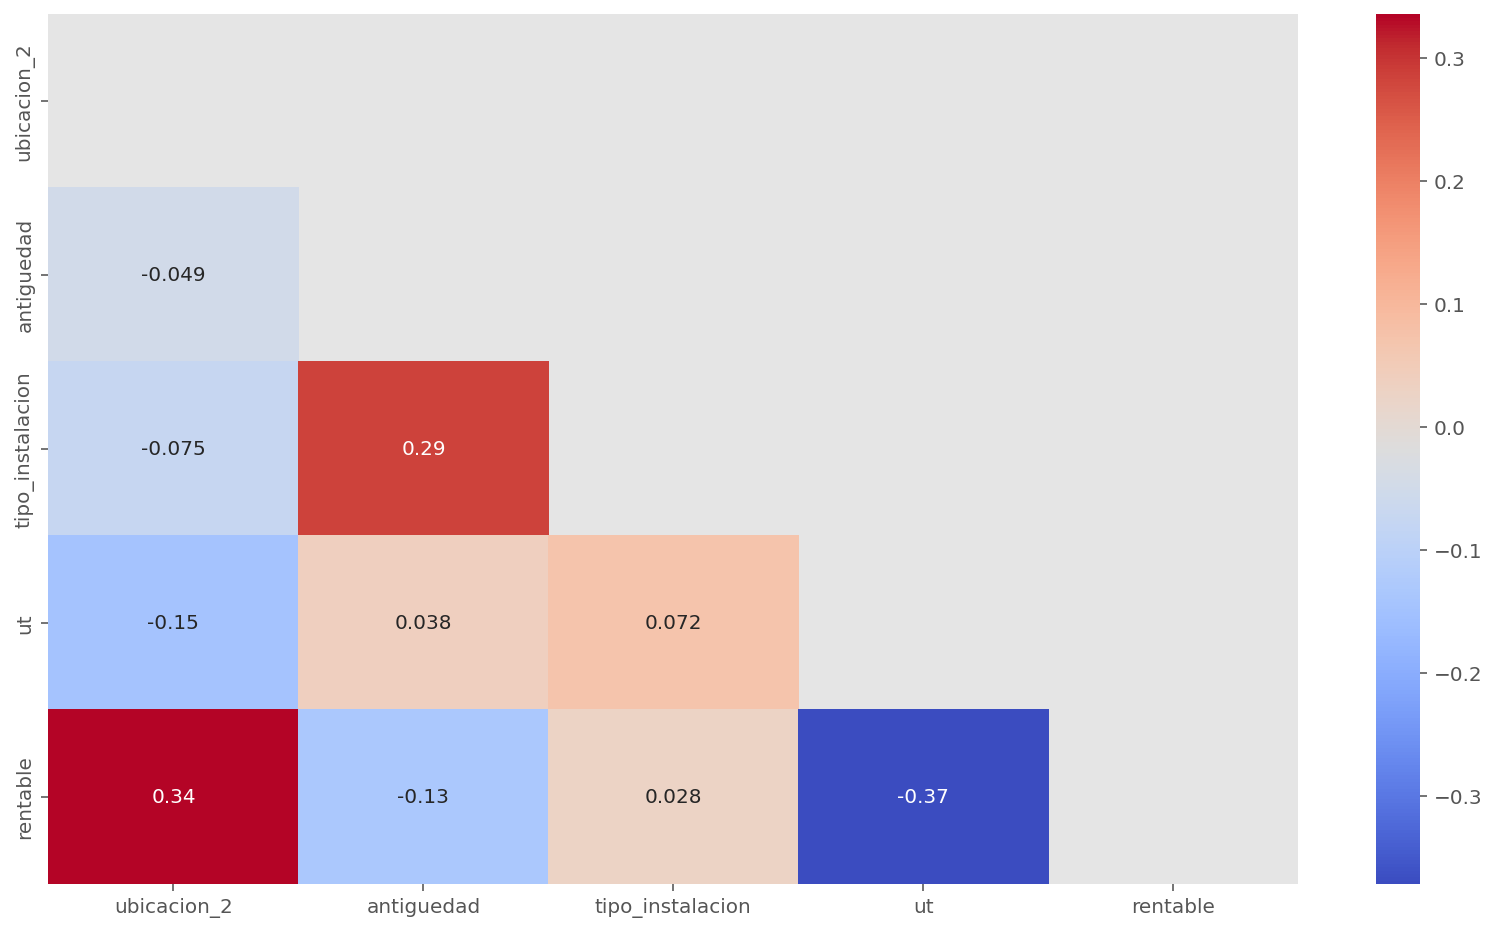

In [94]:
fig, ax = plt.subplots(figsize=(14,8))
mask = np.triu(np.ones_like(atm_filtro.corr(method='spearman')))
dataplop = sns.heatmap(atm_filtro.corr(method='spearman'), cmap = 'coolwarm', annot = True, mask=mask)
plt.show()

**ENTRENANDO EL MODELO**

In [95]:
data_filter = data_filter.to_numpy()
nrow,ncol = data_filter.shape
y = data_filter[:,-1]
X = data_filter[:,0:ncol-1]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,random_state=42)
scaled_X = StandardScaler()
X_train = scaled_X.fit_transform(X_train)
X_test = scaled_X.transform(X_test)
clf1 = LogisticRegression(C=0.01,class_weight="balanced").fit(X_train, y_train)
y_pred1 = clf1.predict(X_test)
y_score1 = clf1.decision_function(X_test)

**Calculando las métricas de evaluación**

In [97]:
fpr1, tpr1, _ = roc_curve(y_test, y_score1, pos_label=clf1.classes_[1])

In [98]:
accuracy_score(y_test, y_pred1)

0.6955555555555556

In [99]:
precision_score(y_test, y_pred1)

0.6877828054298643

In [100]:
recall_score(y_test, y_pred1)

0.6909090909090909

In [101]:
metrics.auc(fpr1, tpr1)

0.7612154150197629

In [102]:
mean_absolute_error(y_test, y_pred1)

0.30444444444444446

In [103]:
mean_squared_error(y_test, y_pred1)

0.30444444444444446

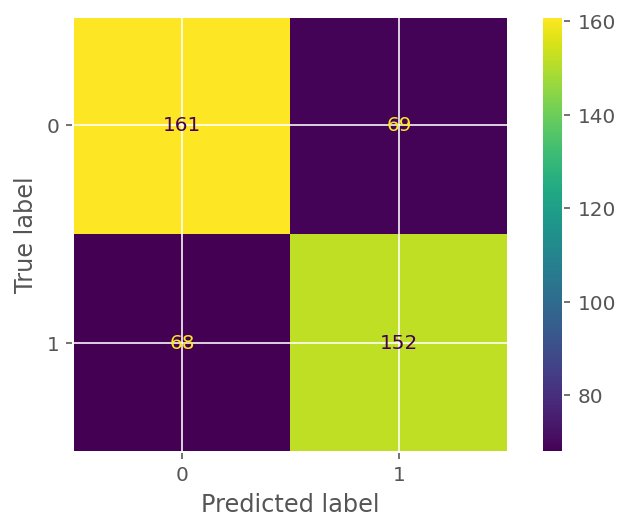

In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred1)

cm_display = ConfusionMatrixDisplay(cm).plot()

**Analizamos las variables para seleccionar aquellas que mejoren nuestro modelo de predicción**

In [89]:
print("Intercept:", clf1.intercept_)
print("Accuracy de entrenamiento:", clf1.score(X, y))
print("Coeficiente:", pd.DataFrame(clf1.coef_, columns=atm_filtro.columns[0:5]).T)


Intercept: [-0.00486949]
Accuracy de entrenamiento: 0.5
Coeficiente:                          0
ubicacion_2       0.469317
antiguedad       -0.203975
tipo_instalacion  0.156700
zonificacion      0.094800
ut               -0.278694


In [90]:
# División de los datos en train y test
X = atm_filtro.drop(columns = 'rentable')
y = atm_filtro['rentable']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )


In [91]:
# Creación del modelo utilizando matrices como en scikitlearn
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.Logit(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.585844
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1050
Model:                          Logit   Df Residuals:                     1044
Method:                           MLE   Df Model:                            5
Date:                Thu, 08 Sep 2022   Pseudo R-squ.:                  0.1546
Time:                        22:48:35   Log-Likelihood:                -615.14
converged:                       True   LL-Null:                       -727.65
Covariance Type:            nonrobust   LLR p-value:                 1.244e-46
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               16.3728      2.564      6.384      0.000      11.346      21.399
ubicacion_2